# Image segmentation

In [5]:
# !pip install -r requirements.txt

In [6]:
# !ipython kernel install --user --name=pix2pix

Select Kernal in jupyter notebook as 'pix2pix'

In [7]:
import tensorflow as tf

import tensorflow_datasets as tfds

In [8]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
import cv2

## Download the Oxford-IIIT Pets dataset

The dataset is [available from TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/oxford_iiit_pet). The segmentation masks are included in version 3+.

In [ ]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

2022-03-13 15:36:29.229767: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


 In addition, the image color values are normalized to the `[0,1]` range. Finally, as mentioned above the pixels in the segmentation mask are labeled either {1, 2, 3}. For the sake of convenience, subtract 1 from the segmentation mask, resulting in labels that are : {0, 1, 2}.

In [ ]:
im_ht, im_wd = 128, 128
model_ht, model_wd = 128, 128 #

In [ ]:
def normalize(input_image, input_mask):
  #input_image = input_image
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [ ]:
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (im_ht, im_wd))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (im_ht, im_wd))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

The dataset already contains the required training and test splits, so continue to use the same splits.

In [ ]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [ ]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

The following class performs a simple augmentation by randomly-flipping an image.
Go to the [Image augmentation](data_augmentation.ipynb) tutorial to learn more.


In [ ]:
def random_shift(images, labels):
    pass

In [ ]:
central_frac = model_ht/im_ht
def center_crop(images, labels):
    images = tf.image.central_crop(images, central_fraction=central_frac)
    labels = tf.image.central_crop(labels, central_fraction=central_frac)
    return images, labels
    

In [ ]:
def random_crop(images, labels):
    concat = tf.concat([images, labels], axis=-1)
    patches = tf.image.random_crop(concat, size=[-1, model_ht, model_wd, 4])
    patch_image = patches[:,:, :, :3]
    patch_mask = tf.expand_dims(patches[:,:, :, 3], axis=-1)

    return patch_image, patch_mask

In [ ]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    seed = tf.random.uniform(shape=(1,), minval=1, maxval=1000000, dtype=tf.int32)
    rng = tf.random.Generator.from_seed(123, alg='philox')
    seed = rng.make_seeds(2)[0]
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    
  
  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    
    #seed = tf.random.uniform(shape=(2,), minval=1, maxval=1000000, dtype=tf.int32)
    #inputs = tf.image.stateless_random_crop(inputs, size=[model_ht, model_wd, 3], seed=seed)
    #labels = tf.image.stateless_random_crop(labels, size=[model_ht, model_wd, 1], seed=seed)
    return inputs, labels

Build the input pipeline, applying the Augmentation after batching the inputs.

In [16]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    #.map(center_crop)
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = (
    test_images
    .batch(BATCH_SIZE)
    #.map(center_crop)
)

Visualize an image example and its corresponding mask from the dataset.

In [17]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


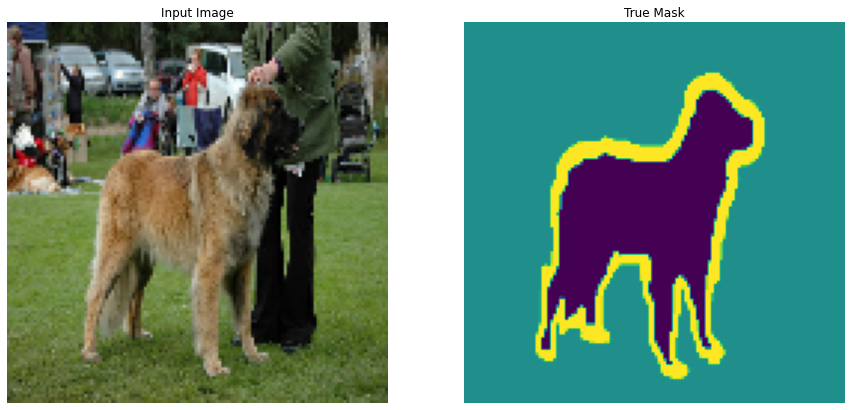

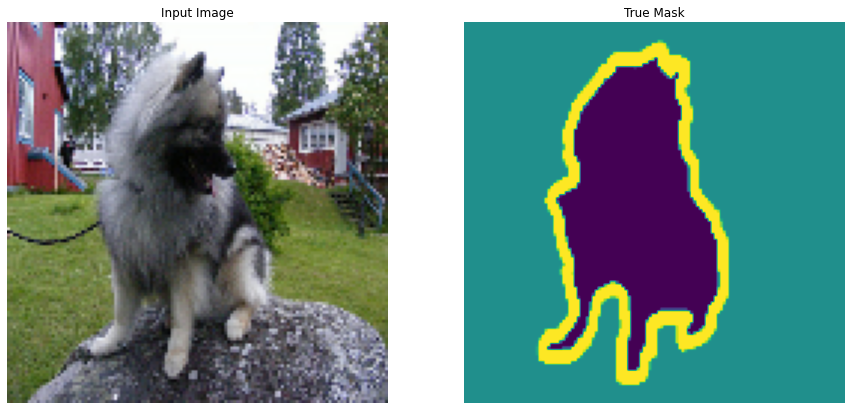

2022-03-10 19:21:38.131997: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [18]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

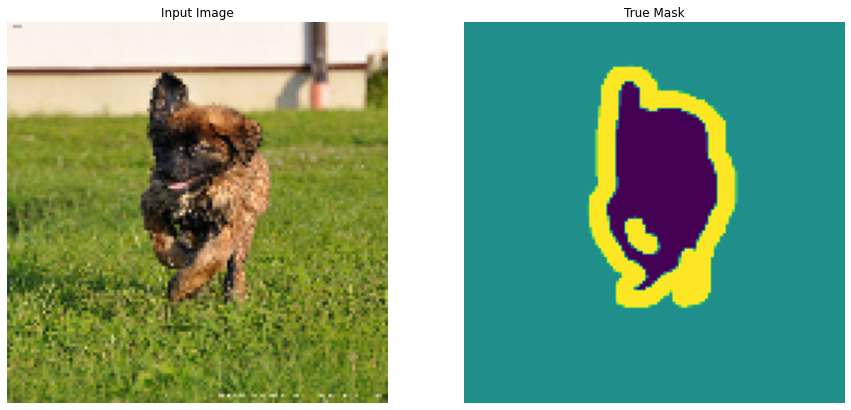

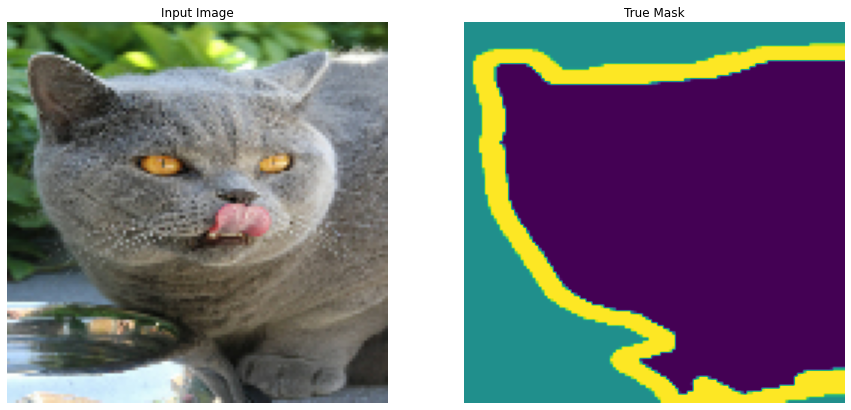

In [19]:
for images, masks in test_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

## Define the model
The model being used here is a modified [U-Net](https://arxiv.org/abs/1505.04597). A U-Net consists of an encoder (downsampler) and decoder (upsampler). In-order to learn robust features and reduce the number of trainable parameters, you will use a pretrained model - MobileNetV2 - as the encoder. For the decoder, you will use the upsample block, which is already implemented in the [pix2pix](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py) example in the TensorFlow Examples repo. (Check out the [pix2pix: Image-to-image translation with a conditional GAN](../generative/pix2pix.ipynb) tutorial in a notebook.)


As mentioned, the encoder will be a pretrained MobileNetV2 model which is prepared and ready to use in `tf.keras.applications`. The encoder consists of specific outputs from intermediate layers in the model. Note that the encoder will not be trained during the training process.

In [20]:
def preprocess(x):
    #x = tf.cast(x, tf.float32)
    #x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
    #x = x/255.0

    return x

In [21]:
def upsample(filters, size, norm_type='batchnorm', apply_dropout=False):
  """Upsamples an input.
  Conv2DTranspose => Batchnorm => Dropout => Relu
  """
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

  if norm_type.lower() == 'batchnorm':
    result.add(tf.keras.layers.BatchNormalization())
  elif norm_type.lower() == 'instancenorm':
    result.add(InstanceNormalization())

  if apply_dropout:
    result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [22]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[None, None, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

The decoder/upsampler is simply a series of upsample blocks implemented in TensorFlow examples.

In [23]:
up_stack = [
    upsample(512, 3),  # 4x4 -> 8x8
    upsample(256, 3),  # 8x8 -> 16x16
    upsample(128, 3),  # 16x16 -> 32x32
    upsample(64, 3),   # 32x32 -> 64x64
]

In [24]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[None, None, 3])
  inputs = preprocess(inputs)

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

Note that the number of filters on the last layer is set to the number of `output_channels`. This will be one output channel per class.

## Train the model

Now, all that is left to do is to compile and train the model. 

Since this is a multiclass classification problem, use the `tf.keras.losses.CategoricalCrossentropy` loss function with the `from_logits` argument set to `True`, since the labels are scalar integers instead of vectors of scores for each pixel of every class. 

When running inference, the label assigned to the pixel is the channel with the highest value. This is what the `create_mask` function is doing.

In [25]:
OUTPUT_CLASSES = 3

model = unet_model(output_channels=OUTPUT_CLASSES)


model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [26]:
#model.summary()

Have a quick look at the resulting model architecture:

In [27]:
#tf.keras.utils.plot_model(model, show_shapes=True)

Try out the model to check what it predicts before training.

In [28]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [29]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

2022-03-10 19:21:47.006141: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8201


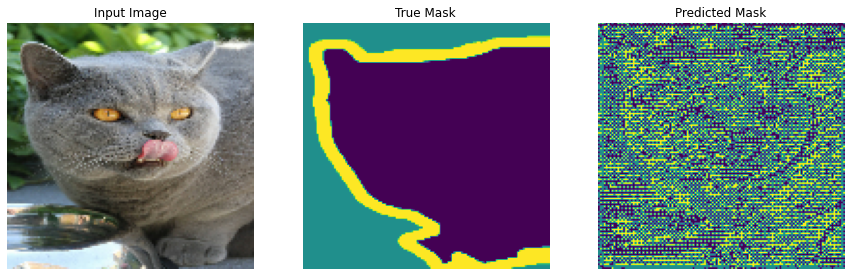

In [30]:
show_predictions()

The callback defined below is used to observe how the model improves while it is training.

In [31]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

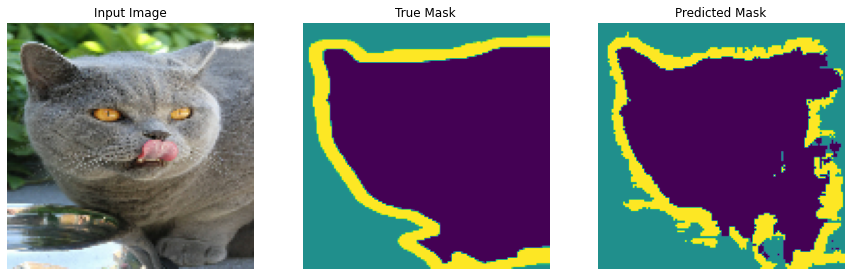


Sample Prediction after epoch 20

57/57 [==============================] - 8s 149ms/step - loss: 0.1875 - accuracy: 0.9170 - val_loss: 0.2902 - val_accuracy: 0.8900


In [32]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()])

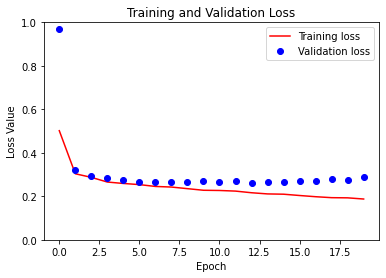

In [33]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

## Make predictions

Now, make some predictions. In the interest of saving time, the number of epochs was kept small, but you may set this higher to achieve more accurate results.

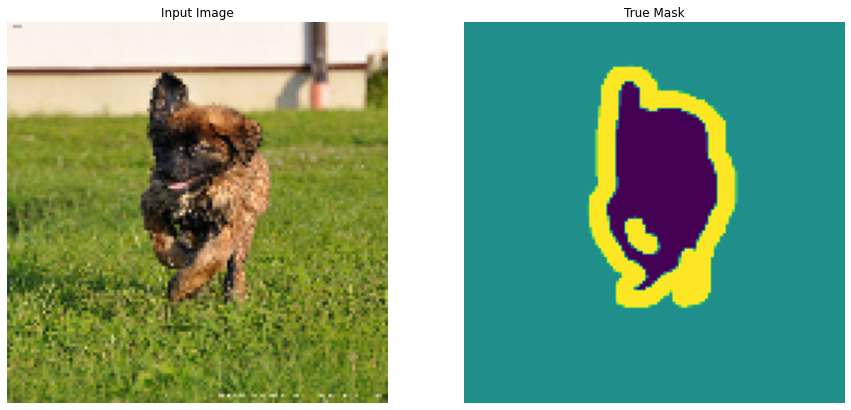

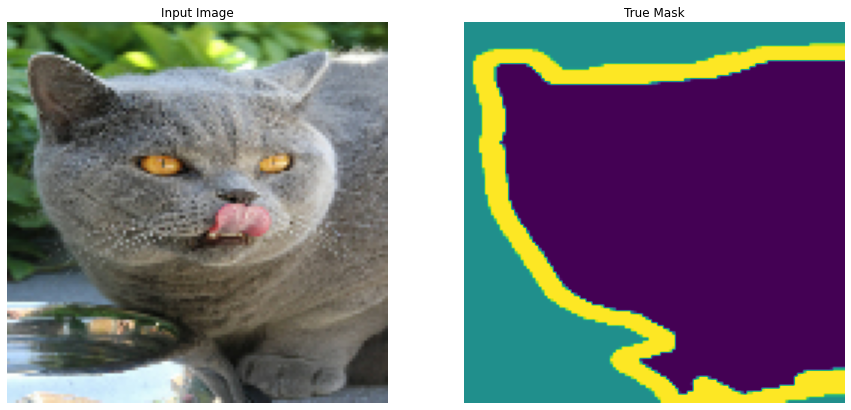

In [34]:
for images, masks in test_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

In [35]:
sample_image.shape

TensorShape([128, 128, 3])

In [36]:
img = sample_image.numpy()
mask = sample_mask.numpy()
img.shape, mask.shape

((128, 128, 3), (128, 128, 1))

 # Predict on 128x128

In [37]:
import cv2
import numpy as np


img2 = img[:128,:128,:]
mask2 = mask[:128,:128]


In [38]:
img2.shape, mask2.shape

((128, 128, 3), (128, 128, 1))

In [39]:
pred2 = model.predict(img2[tf.newaxis, ...])
pred2.shape

(1, 128, 128, 3)

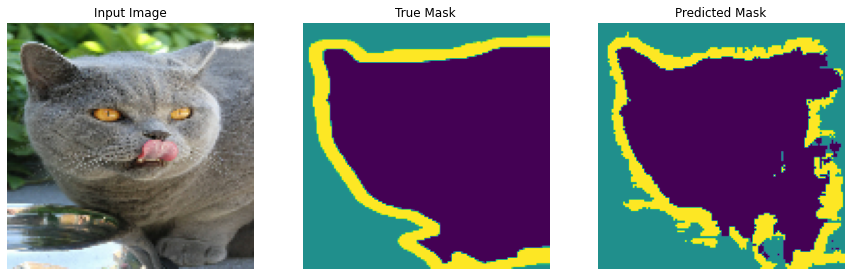

In [40]:
display([img2, mask2,
             create_mask(pred2)])

 # Predict on 5248x2944 (tiled up image)


In [41]:
img1 = np.tile(img,[41,23,1])
mask1 = np.tile(sample_mask,[41,23,1])
img1.shape, mask1.shape

((5248, 2944, 3), (5248, 2944, 1))

In [44]:
pred1 = model.predict(img1[tf.newaxis, ...])
pred1.shape

(1, 5248, 2944, 3)

In [42]:
#%%timeit
#pred1 = model.predict(img1[tf.newaxis, ...])

1.17 s ± 14.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [45]:
pred_mask = create_mask(pred1)
cv2.imwrite('img.png', np.squeeze(img1*255))
cv2.imwrite('mask.png',np.squeeze(pred_mask*128))

True

In [46]:
np.unique(pred1)

array([-10.005352, -10.004639, -10.004622, ...,  13.656816,  13.850241,
        14.001342], dtype=float32)

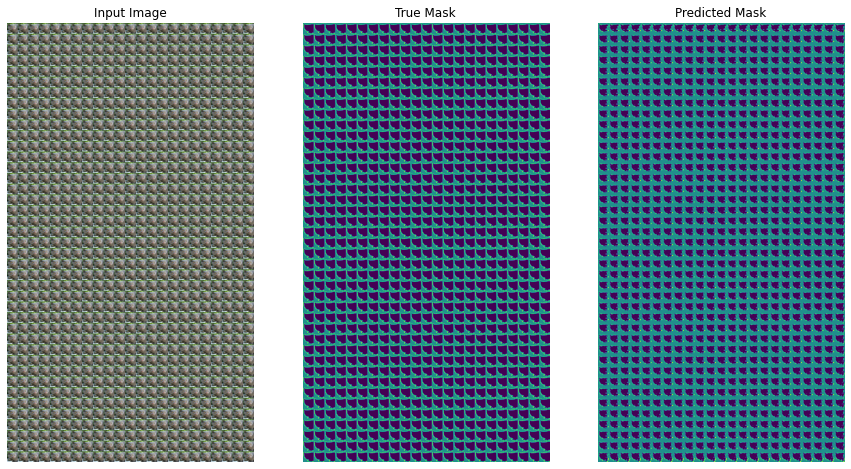

In [47]:
display([img1, mask1,
             create_mask(pred1)])


## Optional: Imbalanced classes and class weights

So, in this case you need to implement the weighting yourself. You'll do this using sample weights: In addition to `(data, label)` pairs, `Model.fit` also accepts `(data, label, sample_weight)` triples.

`Model.fit` propagates the `sample_weight` to the losses and metrics, which also accept a `sample_weight` argument. The sample weight is multiplied by the sample's value before the reduction step. For example:

In [48]:
label = [0,0]
prediction = [[-3., 0], [-3, 0]] 
sample_weight = [1, 10] 

loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True,
                                               reduction=tf.losses.Reduction.NONE)
loss(label, prediction, sample_weight).numpy()

array([ 3.0485873, 30.485874 ], dtype=float32)

So to make sample weights for this tutorial you need a function that takes a `(data, label)` pair and returns a `(data, label, sample_weight)` triple. Where the `sample_weight` is a 1-channel image containing the class weight for each pixel. 

The simplest possible implementation is to use the label as an index into a `class_weight` list:

In [ ]:
def add_sample_weights(image, label):
  # The weights for each class, with the constraint that:
  #     sum(class_weights) == 1.0
  class_weights = tf.constant([2, 0.5, .5])
  class_weights = class_weights/tf.reduce_sum(class_weights)

  # Create an image of `sample_weights` by using the label at each pixel as an 
  # index into the `class weights` .
  sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))

  return image, label, sample_weights

The resulting dataset elements contain 3 images each:

In [ ]:
train_batches.map(add_sample_weights).element_spec

Now you can train a model on this weighted dataset:

In [ ]:
weighted_model = unet_model(OUTPUT_CLASSES)
weighted_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [ ]:
weighted_model.fit(
    train_batches.map(add_sample_weights),
    epochs=1,
    steps_per_epoch=10)

# Infer

In [ ]:
pred1 = weighted_model.predict(img[tf.newaxis, ...])
pred1.shape
display([img, sample_mask,
             create_mask(pred1)])

# Inference Example

In [49]:
image = tf.image.decode_png(tf.io.read_file('cat.jpg'))
result = model(image[tf.newaxis, ...])
result.shape

InvalidArgumentError: Exception encountered when calling layer "concatenate" (type Concatenate).

ConcatOp : Dimension 2 in both shapes must be equal: shape[0] = [1,100,74,512] vs. shape[1] = [1,100,75,576] [Op:ConcatV2] name: concat

Call arguments received:
  • inputs=['tf.Tensor(shape=(1, 100, 74, 512), dtype=float32)', 'tf.Tensor(shape=(1, 100, 75, 576), dtype=float32)']